<a href="https://colab.research.google.com/github/Jorbnc/MAIA-DL/blob/master/Mini_Proyecto_1_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

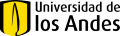

<span style="font-family:Cambria Math">
    
# Mini Proyecto 1, Técnica de *Deep Learning*: Clasificación de MRI con Redes Neuronales Convolucionales para Tipos de Cáncer

## Descripción del problema:

La resonancia magnética (MRI) desempeña un papel fundamental en la detección y
clasificación de los diferentes tipos de cáncer cerebral. La aplicación de redes
neuronales convolucionales (CNN) ha incrementado notablemente la precisión en la
interpretación de estos volúmenes, al ser entrenadas para reconocer patrones y
características distintivas asociadas a cada tipo de tumor. Las resonancias
magnéticas (MRI) generan volúmenes tridimensionales compuestos por múltiples
capas, donde cada una corresponde a una imagen bidimensional del tejido analizado.
Procesar un volumen completo implica manejar una gran cantidad de datos
simultáneamente, lo que puede ser computacionalmente costoso y requerir
considerable tiempo y recursos. Para este proyecto se trabajará exclusivamente con
imágenes individuales extraídas de las capas de los MRI, en lugar de procesar el
volumen completo. Esta estrategia simplifica la tarea al transformar el problema en
una clasificación de imágenes bidimensionales, reduciendo significativamente la
carga computacional.

## Objetivo:

Desarrollar un método basado en redes neuronales convolucionales que permita
clasificar con exactitud imágenes extraídas de MRIs en una de las 4 categorías.

- Glioma: Detecta masas anómalas con bordes irregulares y heterogeneidad en
el tejido cerebral.
- Meningioma: Identifica tumores bien delimitados originados en las meninges.
- Pituitary: Clasifica adenomas hipofisarios en la región selar.
- Tejido sano: Diferencia el tejido cerebral normal sin anomalías presentes
*****
</span>

***

<div class="alert alert-block alert-info">
<bNotar:</b >

**Este proyecto es realizado por Andrés Felipe Ñungo y Jordan Bryan Núñez Campos para entrega el 2 de mayo.**
</div24></span>

Tareas:
- Ajustar el código para tomar un solo canal (Andrés Ñungo)
- Tomar los papers investigar en la teoría como se debería ver un cerebro enfermo (Andrés Ñungo)
-


<span style="font-family:Cambria Math">

***
    
# Índice
XXXXXX

1. [Instalación y carga de librerías](#instalacion-y-carga-de-librerias)
(#ejercicio-didactico-uso-de-la-cota-de-chernoff)
7. [Referencias](#referencias)
</span>

***

<span style="font-family:Cambria Math">

# 1. Instalación y cargue de librerías
</span>

***

<span style="font-family:Cambria Math">

*** Nota: por lo que veo el equipo de monitores está más inclinado hacia usar Pytorch ***
</span>

In [1]:
# Librerías básicas
import os
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Sklearn
from sklearn.metrics import confusion_matrix, accuracy_score , precision_recall_curve, roc_auc_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split

In [2]:
#Visulización adecuada de gráficas en notebook
%matplotlib inline

In [ ]:
# Ignorar las warnings
#import warnings
#warnings.filterwarnings("ignore")

In [3]:
from importlib.metadata import version
#Librerias usadas
librerias = ['numpy', 'scikit-learn', 'torch', 'joblib']
for library in librerias:
  print(library, ": ", version(library))

numpy :  2.0.2
scikit-learn :  1.6.1
torch :  2.6.0+cu124
joblib :  1.4.2


***
<span style="font-family:Cambria Math">

# 2. Análisis exploratorio y preparación de los datos

Sugiero algunas consideraciones de temas de forma:
- Para citar dentro del notebook usar súper-índices, por ejemmplo: [¹]
- Palabras en *english* usar cursivas
- Variables o parámetros usar la siguiente notación:  **`variable`**
</span>

In [4]:
import kagglehub

# Download latest version
path_kaggle = kagglehub.dataset_download("rm1000/brain-tumor-mri-scans")
print("Path to dataset files:", path_kaggle)

Path to dataset files: /kaggle/input/brain-tumor-mri-scans


In [ ]:
#

In [5]:
labels = ['glioma', 'healthy', 'meningioma', 'pituitary']
label2idx = {label: idx for idx, label in enumerate(labels)}
idx2label = {v: k for k, v in label2idx.items()}

# Cargar solo los paths de las imágenes
path_raiz = path_kaggle
dir_paths = {label: os.path.join(path_raiz, label) for label in labels}

# Dataframe con los paths
df_paths = []
for label, path in dir_paths.items():
    imagenes = os.listdir(path)
    for img in imagenes:
        if img.lower().endswith('.jpg'):
            img_path = os.path.join(path, img)
            df_paths.append({'img_path': img_path, 'label': label})

df_paths = pd.DataFrame(df_paths)
df_paths.head()

,img_path,label
0,/kaggle/input/brain-tumor-mri-scans/glioma/066...,glioma
1,/kaggle/input/brain-tumor-mri-scans/glioma/126...,glioma
2,/kaggle/input/brain-tumor-mri-scans/glioma/073...,glioma
3,/kaggle/input/brain-tumor-mri-scans/glioma/010...,glioma
4,/kaggle/input/brain-tumor-mri-scans/glioma/037...,glioma


***
<span style="font-family:Cambria Math">

XXXXXXX
</span>

In [ ]:
# Pipeline que reduce las dimensiones y convierte a Tensor
transform_pipeline = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [ ]:
# Subclase de Dataset de PyTorch (para cargar más eficientemente la data)
class ImgDataset(Dataset):
    def __init__(self, dataframe, transformacion=None, label2idx=None):
        self.dataframe = dataframe
        self.transformacion = transformacion
        self.label2idx = label2idx or {}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        fila = self.dataframe.iloc[idx]
        img_path = fila['img_path']
        label = fila['label']

        # Si los labels son strings, conviértelos a índices (si label2idx está definido)
        if self.label2idx:
            label = self.label2idx[label]

        # Leer y convertir a RGB
        with Image.open(img_path) as img:
            img = img.convert('RGB')

            # Aplicar transformación custom o solo a Tensor
            img = self.transformacion(img) if self.transformacion else transforms.ToTensor()(img)

        return img, label


# Instanciación de la clase de Dataset
dataset = ImgDataset(df_paths, transformacion=transform_pipeline, label2idx=label2idx)

***
<span style="font-family:Cambria Math">

XXXXXXXX

</span>

In [ ]:
dataset[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 0)

***
<span style="font-family:Cambria Math">

XXXXXXX
</span>

***
<span style="font-family:Cambria Math">

XXXXXX
</span>

***
<span style="font-family:Cambria Math">

# 3. Limpieza y definición de *pipelines* de preprocesamiento

</span>

***
<span style="font-family:Cambria Math">

## 3.1 Análisis de la Distribución de los Datos

*** Resize de las imágenes***
</span>

In [ ]:
# Copia de los datos
data = data_raw.copy()

In [ ]:
#Eliminación de duplicados
data.drop_duplicates(inplace=True)
print(f'Duplicados: {data.duplicated().sum()}')
data.shape

Duplicados: 0


(5318, 12)

***
<span style="font-family:Cambria Math">

XXXXXX
</span>

***

<span style="font-family:Cambria Math">

## 3.2 *Pipeline* de Preprocesamiento
XXXXXXX
</span>

***

<span style="font-family:Cambria Math">

XXXXXXXXX
</span>

In [ ]:
# Deginición de objetos
smote = SMOTE(k_neighbors=3, random_state=RANDOM_STATE)
scaler = RobustScaler()

In [ ]:
#Definición de objeto de cross-validación estratificada
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [ ]:
counts = y_train_over.value_counts()
print(counts)

quality
6    1858
5    1858
7    1858
3    1858
4    1858
8    1858
9    1858
Name: count, dtype: int64


In [ ]:
# # Para visualizar la estructura del modelo se puede usar la clase plot_model,
# # previamente se habia cargado esta clase en las librerías. Al visualizar el
# # modelo también se puede guardar o exportar la imagen resultante.

# # Parámetros plot_model:
# # modelo = modelo neuronal detensorflow.keras
# # to_file = nombre del archivo de la imagen del diagrama
# # show_shapes = parámetro binario para definir si se muestran las dimensiones
# # show_layer_names = parámetro binario para definir si se incluyen los nombres de las capas
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

***

<span style="font-family:Cambria Math">

XXXXXXXX
</span>

***

<span style="font-family:Cambria Math">

# 4. Entrenamiento de los Modelos y Búsqueda de Hiperparámetros

- **`LogisticRegression`**




</span>

***

<span style="font-family:Cambria Math">

XXXXXX.

> **Nota aclaratoria:**  
> XXXXX
>  
> XXXXX

</span>

***
<span style="font-family:Cambria Math">

# 6. Análisis de resultados y conclusiones

XXXXXX
</span>

In [ ]:
# def visualization_history(resultsFit):
#     """
#     Esta función grafica las curvas de precisión a lo largo de las épocas de entrenamiento
#     para el conjunto de prueba como el de validación.
#     Parámetros:
#     resultsFit = historial de entrenamiento de un modelo entensorflow.keras
#     Salida:
#     Gráfica de la precisión en validación y prueba.
#     """
#     # Llamado al entrono de la gráfica y fijar tamaño de visualización
#     fig, axes = plt.subplots(1, 2, figsize=(13, 5))

#     # Graficar la presición de la historia en entrenamiento
#     axes[0].plot(range(len(resultsFit.history['accuracy'])), resultsFit.history['accuracy'],
#            '#5a2ff4', linestyle = "-", marker = "o",
#            label='Precisión entrenamiento', lw = 3)

#     # Graficar la presición de la historia en validación
#     axes[0].plot(range(len(resultsFit.history['val_accuracy'])), resultsFit.history['val_accuracy'],  '#60d13e',
#            label='Precisión validación', linestyle = '-', marker = 'o', lw = 3)

#     # Umbral 90% de precisión
#     axes[0].plot(range(len(resultsFit.history['val_accuracy'])), 0.9*np.ones(len(resultsFit.history['val_accuracy'])),
#                'red', lw = 3, label = 'Umbral')

#     # Títulos de los ejes
#     axes[0].set_xlabel('Época',fontsize=16)
#     axes[0].set_ylabel(r'Precisión',fontsize=16)
#     axes[0].set_ylim(top=1) # Límite de la grafica
#     axes[0].grid()      # Activar la cuadricula
#     axes[0].legend(fontsize=14,loc = 'lower right')   # Establecer la legenda


#     # Graficar la pérdida de la historia en entrenamiento
#     axes[1].plot(range(len(resultsFit.history['loss'])), resultsFit.history['loss'],
#            '#5a2ff4', linestyle = "-", marker = "o",
#            label='Pérdida entrenamiento', lw = 3)

#     # Graficar la presición de la historia en validación
#     axes[1].plot(range(len(resultsFit.history['val_loss'])), resultsFit.history['val_loss'],  '#60d13e',
#            label='Pérdida validación', linestyle = '-', marker = 'o', lw = 3)

#     # Títulos de los ejes
#     axes[1].set_xlabel('Época',fontsize=16)
#     axes[1].set_ylabel(r'Pérdida',fontsize=16)
#     axes[1].grid()      # Activar la cuadricula
#     axes[1].legend(fontsize=14,loc = 'upper right')   # Establecer la legenda


#     plt.tight_layout() # Ajusta automáticamente el diseño de la figura
#     plt.show()

In [ ]:
# # Evaluación del modelo en el conjunto de prueba
# results = model.evaluate(X_test, y_test_onehot)

# # Los resultados contendrán los valores de las métricas definidas, por ejemplo, pérdida y precisión.
# print(f'Pérdida en el conjunto de prueba: {results[0]:0.2f}')
# print(f'Precisión en el conjunto de prueba:{results[1]:0.2f}')

***
<span style="font-family:Cambria Math">

XXXXXXX
</span>

***
<span style="font-family:Cambria Math">

# 7. Referencias
</span>

***
<span style="font-family:Cambria Math">

[¹] **Solución Taller 1, Curso ML No Supervisado**  
Disponible en: [Coursera - Machine Learning No Supervisado](https://www.coursera.org/learn/maia-machine-learning-no-supervisado/supplement/fXisI/solucion-al-problema-practicon)

[²] **Ídem.**

[³] **Taller 2, Curso ML Supervisado**  
Disponible en: [Coursera - Machine Learning Supervisado](https://www.coursera.org/learn/maia-machine-learning-supervisado/programming/oqZpF/efecto-de-los-datos-en-la-generacion-de-modelos)

[⁴] **Lección 1, Semana 7, Curso ML Supervisado**  
Disponible en: [Coursera - Machine Learning Supervisado](https://www.coursera.org/learn/maia-machine-learning-supervisado/programming/MFHfh/clasificacion-binaria-no-balanceada-con-y-sin-costos)

[⁵] **Lección 1, Semana 4, Curso ML Supervisado**  
Disponible en: [Coursera - Machine Learning Supervisado](https://www.coursera.org/learn/maia-machine-learning-supervisado/programming/iMjb1/clasificacion-y-regresion-simple-diferentes-modelos/lab?path=%2Fnotebooks%2Frelease%2FSemana4Leccion1%2FSemana4Leccion1.ipynb)

[⁶] **Taller 6, Curso ML Supervisado**  
Disponible en: [Coursera - Machine Learning Supervisado](https://www.coursera.org/learn/maia-machine-learning-supervisado/programming/a9xeR/problema-de-clasificacion-usando-un-ensamble-de-arboles)

[⁷] **Taller 4, Curso ML Supervisado**  
Disponible en: [Coursera - Machine Learning Supervisado](https://www.coursera.org/learn/maia-machine-learning-supervisado/programming/lI87o/seleccion-de-modelo-y-regularizacion-en-redes-neuronales)

[⁸] **Lección 1, Semana 6, Curso ML Supervisado**  
Disponible en: [Coursera - Machine Learning Supervisado](https://www.coursera.org/learn/maia-machine-learning-supervisado/programming/t5nSQ/problema-de-clasificacion-con-random-forest)

[⁹] **Ídem.**

[¹⁰] **Cotas de Chernoff**  
Disponible en: [Wikipedia - Cotas de Chernoff](https://es.wikipedia.org/wiki/Cotas_de_Chernoff)

</span>





